In [1]:
from pathlib import Path

import extinction
import numpy as np
import pandas as pd
import sfdmap
from matplotlib import pyplot as plt
from scipy.ndimage.filters import median_filter
from sndata.sdss import Sako18Spec

In [2]:
s18 = Sako18Spec()
s18.download_module_data()

dust_dir = Path('.').resolve().parent / 'spec_analysis' / 'schlegel98_dust_map'
results_dir = Path('.').resolve().parent / 'results'

pipeline_data = pd.read_csv(results_dir / 'final_sdss.csv', index_col=['obj_id', 'time'])
pd.concat([d[1] for d in pipeline_data.groupby('obj_id') if len(d[1]) >= 7])

feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}

In [16]:
def plot_sdss_spectrum_measurements(obj_id, time, feat_choice, rv=3.1, bin_size=10, figsize=(10, 6)):
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    dust_map = sfdmap.SFDMap(dust_dir)
    mwebv = dust_map.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    rest_wave = wave / (1 + sdss_data.meta['z'])
    rest_flux = flux * 10 ** (0.4 * mag_ext)
    bin_flux = median_filter(rest_flux, bin_size)
    
    fig, axis = plt.subplots(figsize=figsize)

    fill_feat = feat_choice
    #index = fill_feat - 1
 
    feature_measurements = pipeline_data.loc[int(obj_id), time]
    for feat, feat_data in feature_measurements.groupby('feat_name').apply(fill_feat):
        feat_start = feat_data.feat_start.iloc[0]
        flux_start = np.interp(feat_start, rest_wave, bin_flux)
        
        feat_end = feat_data.feat_end.iloc[0]
        flux_end = np.interp(feat_end, rest_wave, bin_flux)
        
        i = np.where((feat_start <= rest_wave) & (rest_wave <= feat_end))[0]
        x = rest_wave[i]
        y2 = rest_flux[i]
        
        fit_params = np.polyfit([feat_start, feat_end], [flux_start, flux_end], 1)
        fit_func = np.poly1d(fit_params)
        y = fit_func(x)
 
        axis.fill_between(x, y2, y, alpha=.4, label=f'{feature_alias[feat]} ({feat})')
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', linewidth=.5)
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1)
    
    axis.legend()
    axis.set_xlabel('Wavelength')
    axis.set_ylabel('Flux')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.


TypeError: 'str' object is not callable

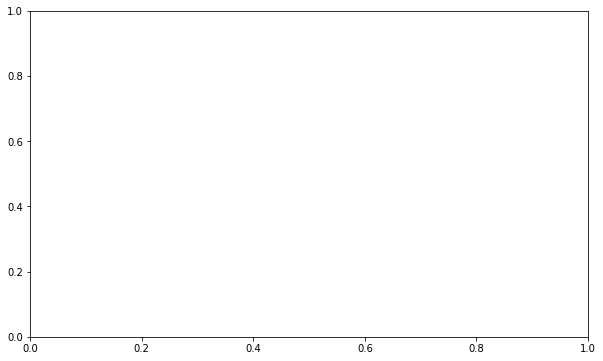

In [17]:
plot_sdss_spectrum_measurements(1241, 2453636.5, 'pW3')
plt.xlim(3500, 6500)
plt.ylim(0)